In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats 
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

from neural_processes.data import gaussian_process as gp

plt.style.use("seaborn")

# Generate in pure tensorflow
Below is Deepmind's curve generation object.
- Uses the classic Gaussian / radial basis function kernel
- Number of context & target points, and their x locations are set per-batch
- Kernel hyperparameters randomized within-batch
- x_size, y_size = 1, 1 corresponds to the easy-to-plot 1D case

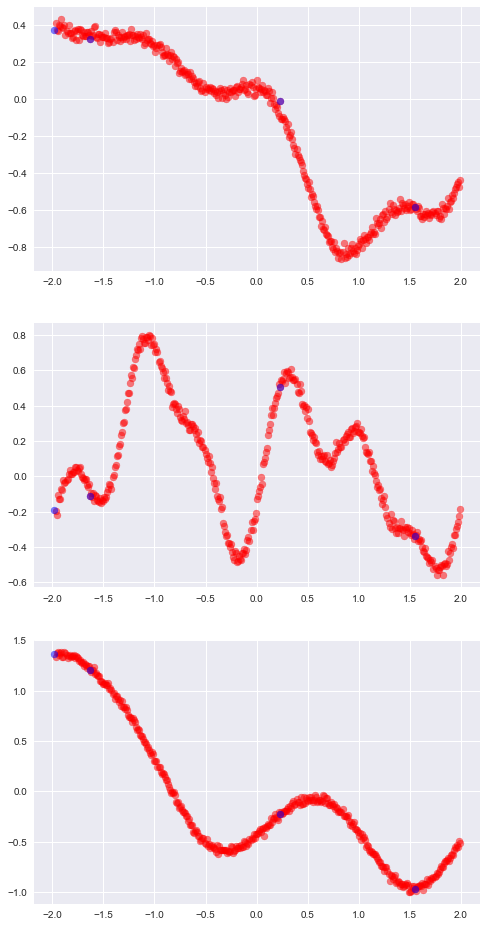

In [2]:
testing = True
curves = gp.tf.CurveGenerator(batch_size=100, max_num_context=20, testing=testing).generate_curves()


n = 3
_, axes = plt.subplots(n, figsize=(8, 5.5 * n))
for i in range(n):
    context_x = curves.query[0][0][i]
    context_y = curves.query[0][1][i]
    len_context = context_x.shape[0]
    # The targets include all the context points so just take the unseen ones
    target_x = curves.query[1][i][len_context: , :]
    target_y = curves.target_y[i][len_context:, :]
    
    axes[i].scatter(target_x, target_y, color="red", alpha=0.5)
    axes[i].scatter(context_x, context_y, color="blue", alpha=0.5)

# Translation to PyTorch

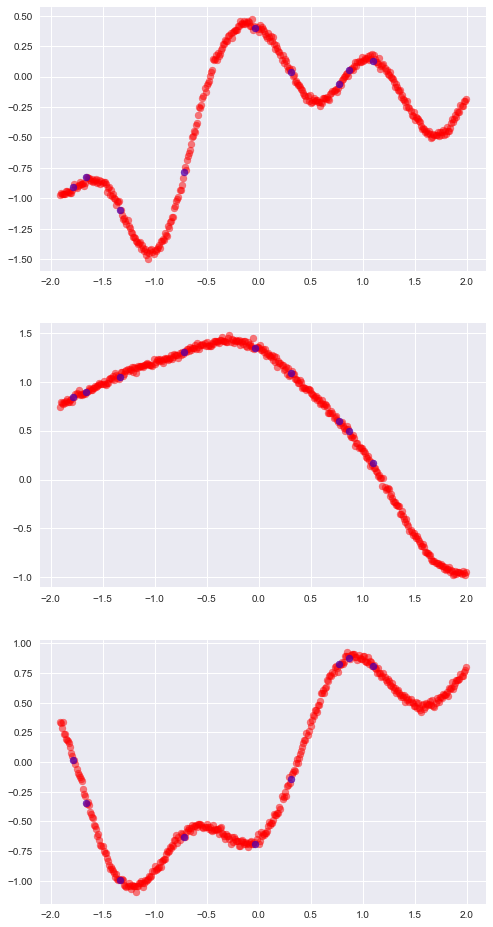

In [3]:
testing = True
curves = gp.torch.CurveGenerator(batch_size=100, max_num_context=20, testing=testing).generate_curves()


n = 3
_, axes = plt.subplots(n, figsize=(8, 5.5 * n))
for i in range(n):
    context_x = curves.query[0][0][i]
    context_y = curves.query[0][1][i]
    len_context = context_x.shape[0]
    # The targets include all the context points so just take the unseen ones
    target_x = curves.query[1][i][len_context: , :]
    target_y = curves.target_y[i][len_context:, :]
    
    axes[i].scatter(target_x, target_y, color="red", alpha=0.5)
    axes[i].scatter(context_x, context_y, color="blue", alpha=0.5)

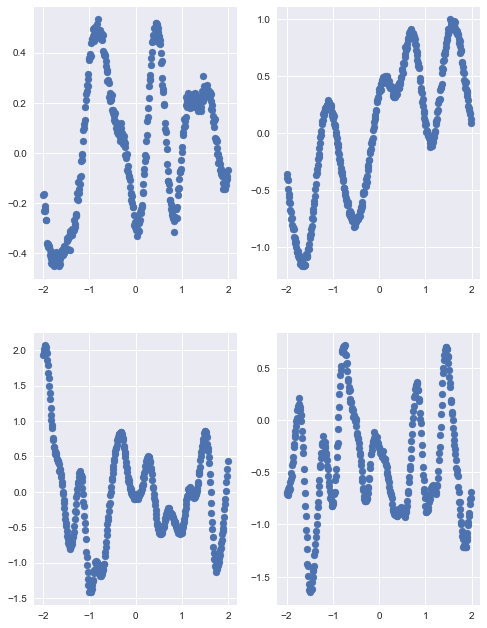

In [4]:
batch_size = 256
generator = gp.torch.CurveGenerator(batch_size=batch_size, max_num_context=None, testing=None)

x_values = generator.get_test_x_values()
l1, sigma_f = generator.get_kernel_hyperparams()
kernel = generator.gaussian_kernel(x_values, l1, sigma_f)


cholesky_y = generator._sample_cholesky(kernel)
direct_y = generator._sample_direct(kernel)

n = 2
_, axes = plt.subplots(n, 2, figsize=(8, 5.5 * n))
for i in range(n):
    axes[i][0].scatter(x_values[i], cholesky_y[i])
    axes[i][1].scatter(x_values[i], direct_y[i])

In [5]:
batch_size = 256
generator = gp.torch.CurveGenerator(batch_size=batch_size, max_num_context=20, testing=None)

l1, sigma_f = generator.get_kernel_hyperparams()

test_x_values = generator.get_test_x_values()
test_kernel = generator.gaussian_kernel(test_x_values, l1, sigma_f)

train_x_values = generator.get_train_x_values(num_context=15)
train_kernel = generator.gaussian_kernel(train_x_values, l1, sigma_f)

%timeit cholesky_y = generator._sample_cholesky(test_kernel)
%timeit direct_y = generator._sample_direct(test_kernel)
%timeit cholesky_y = generator._sample_cholesky(train_kernel)
%timeit direct_y = generator._sample_direct(train_kernel)

1.21 s ± 87.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
759 ms ± 41.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
624 µs ± 22.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
732 µs ± 24.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
batch_size = 512
generator = gp.torch.CurveGenerator(batch_size=batch_size, max_num_context=20, testing=None)

l1, sigma_f = generator.get_kernel_hyperparams()

test_x_values = generator.get_test_x_values()
test_kernel = generator.gaussian_kernel(test_x_values, l1, sigma_f)

train_x_values = generator.get_train_x_values(num_context=15)
train_kernel = generator.gaussian_kernel(train_x_values, l1, sigma_f)

%timeit cholesky_y = generator._sample_cholesky(test_kernel)
%timeit direct_y = generator._sample_direct(test_kernel)
%timeit cholesky_y = generator._sample_cholesky(train_kernel)
%timeit direct_y = generator._sample_direct(train_kernel)

2.81 s ± 620 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.61 s ± 73.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.79 ms ± 350 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.48 ms ± 95.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
batch_size = 1024
generator = gp.torch.CurveGenerator(batch_size=batch_size, max_num_context=20, testing=None)

l1, sigma_f = generator.get_kernel_hyperparams()

test_x_values = generator.get_test_x_values()
test_kernel = generator.gaussian_kernel(test_x_values, l1, sigma_f)

train_x_values = generator.get_train_x_values(num_context=15)
train_kernel = generator.gaussian_kernel(train_x_values, l1, sigma_f)

%timeit cholesky_y = generator._sample_cholesky(test_kernel)
%timeit direct_y = generator._sample_direct(test_kernel)
%timeit cholesky_y = generator._sample_cholesky(train_kernel)
%timeit direct_y = generator._sample_direct(train_kernel)

5.84 s ± 891 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.35 s ± 251 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.62 ms ± 628 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.24 ms ± 92.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Directly sampling looks like it might be tiny bit faster, but relatively inconsequential - provided we limit the use of the testing version. Actually I think it uses the Cholesky decomposition in the direct version anyway, so not sure why it would be faster...

# Option 3: generate straight outta the kernel function in numpy/scipy.stats
Not really much point since it's readily available in Pytorch & TF

In [8]:
def covariance(x, y, theta_0=1, length=1):
    # Force the arrays to broadcast to 2D (len(x), len(y)) matrix
    x = x[:, np.newaxis]
    y = y[np.newaxis, :]
    return theta_0 * np.exp(-(x - y) ** 2 / (2 * length **2))

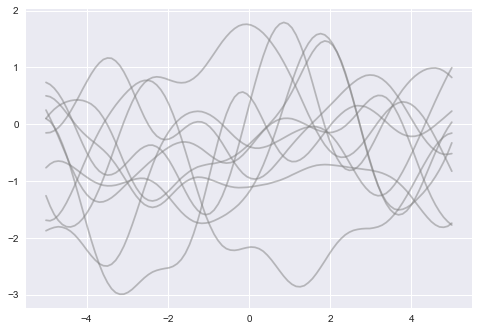

In [9]:
# Via scipy.stats
epsilon = 1e-6
x = np.linspace(-5, 5, 100)

dist = stats.multivariate_normal(
    mean=np.zeros_like(x),
    cov=covariance(x, x) + epsilon * np.eye(len(x)),
    allow_singular=True
)

for _ in range(10):
    plt.plot(x, dist.rvs(1), alpha=0.5, color="grey")

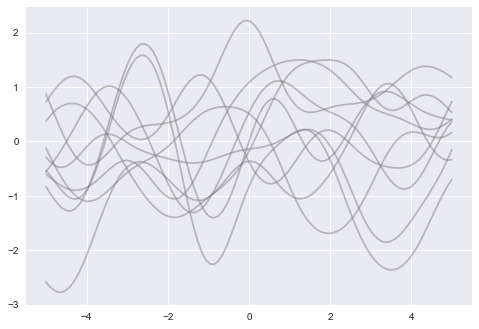

In [10]:
# Via numpy
epsilon = 1e-6
x = np.linspace(-5, 5, 100)

dist = np.random.multivariate_normal(
    mean=np.zeros_like(x),
    cov=covariance(x, x) + epsilon * np.eye(len(x)),
    size=10
)

for sample in dist:
    plt.plot(x, sample, alpha=0.5, color="grey")

# Option 4: generate via sampling prior from sklearn `GaussianProcessRegressor`
Not really much point since it's readily available in Pytorch & TF (easy to create new valid kernels though)

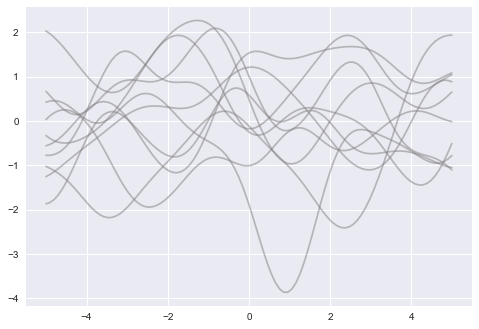

In [11]:
length = 1
theta_0 = 1

kernel = kernels.ConstantKernel(theta_0) * kernels.RBF(length_scale=length)

gp = GaussianProcessRegressor(
    kernel=kernel
)

x_plot = np.linspace(-5, 5, 100)

samples = gp.sample_y(x_plot.reshape(-1, 1), n_samples=10)

for i in range(10):
    plt.plot(x_plot, samples[:, i], alpha=0.5, color="grey")